In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import copy
from scipy.signal import find_peaks, resample
from icecream import ic
from collections import OrderedDict

from neurolib.models.aln import ALNModel
from neurolib.models.multimodel import ALNNetwork, ALNNode, MultiModel

#from neurolib.models.aln import ALNModel_SaveSteps
import neurolib.utils.stimulus as stim
import neurolib.utils.functions as func  
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
import os
import sys
from pynverse import inversefunc

from intersect import intersection
from scipy.stats import mode


sys.path.insert(0, '..')
from prc_funcs import *
from functions import *
    

import matplotlib.colors as mcolors

colors = mcolors.TABLEAU_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
colrs = [name for hsv, name in by_hsv]

#hide
import logging
logging.getLogger().setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")

BASE_PATH = "../../../../" # need to go back from default hdf path "./data/hdf"
HDF_PATH = BASE_PATH + "Data/"


## Kegl = 50 to see fold points

In [2]:
sampling = 1
aln = ALNModel()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.01
aln.params['sampling_dt'] = aln.params.dt * sampling
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.
#aln.params['Ke_gl'] = 30.
prc = PRC_ALN(aln)

INFO:root:aln: Model initialized.
ic| domfreq: 21.50526315789473


initialised ...


In [3]:
#prc.calc_prc_xcorr(
#    itype="real", 
#    Ke_gl=50, 
#    num_points=300)

In [4]:
#np.save('../data/PRC_real_Kegl=50.npy', prc.prc_xcorr) 
prc_xcorr = np.load('data/PRC_real_Kegl=50.npy',allow_pickle='TRUE').item()

In [5]:
def lambda_factory(ab):
    return lambda x:x*ab[0]+ab[1]

def broken_line(x, x0, y0):
    cl = []
    fl = []
    for i in range(len(x0)-1):
        ab = np.polyfit(x0[i:i+2], y0[i:i+2], 1)
        #ic(ab)
        # Compute and append a "condition" interval
        cl.append(np.logical_and(x >= x0[i], x <= x0[i+1]))
        # Create a line function for the interval
        fl.append(lambda_factory(ab))
    return(np.piecewise(x, condlist=cl, funclist=fl))


def f1(x):
    return broken_line(x, x1, y1)

def f2(x):
    return broken_line(x, x2[::-1], y2[::-1])

def f(xy):
    x, y = xy
    z = np.array([y - f1(x), y - f2(x)])
    return z

In [6]:
period_fr = prc.frperiod
phis = np.asarray(list(prc_xcorr.keys()))
prcs = np.asarray(list(prc_xcorr.values()))

# Have a data point for phi=0 and phi=T
phis = np.concatenate(([0.], phis))
phis = np.concatenate((phis, [period_fr]))
prcs = np.concatenate(([prcs[0]], prcs))
prcs = np.concatenate((prcs, [prcs[-1]]))
def prc_func(x):
    return broken_line(x, phis, prcs) 

## calc eq. phases with inversion

In [7]:
Phases = {}

# k = 1
ds = np.arange(0, prc.frperiod, 0.2)
for d in ds:
    Phases[d] = d

for k in [2, 3, 4]:
    def m(phi):
        return (phi%prc.frperiod)/(k-1) - prc_func(phi%prc.frperiod)

    invM = inversefunc(m)
    
    ds = np.arange((k-1)*prc.frperiod, k*prc.frperiod, 1)
    for d in ds:
        ph = invM(d/(k-1) - prc.frperiod)
        Phases[d] = ph


In [8]:
d = np.asarray(list(Phases.keys()))
p = np.asarray(list(Phases.values()))
T = prc.frperiod - prc_func(p)

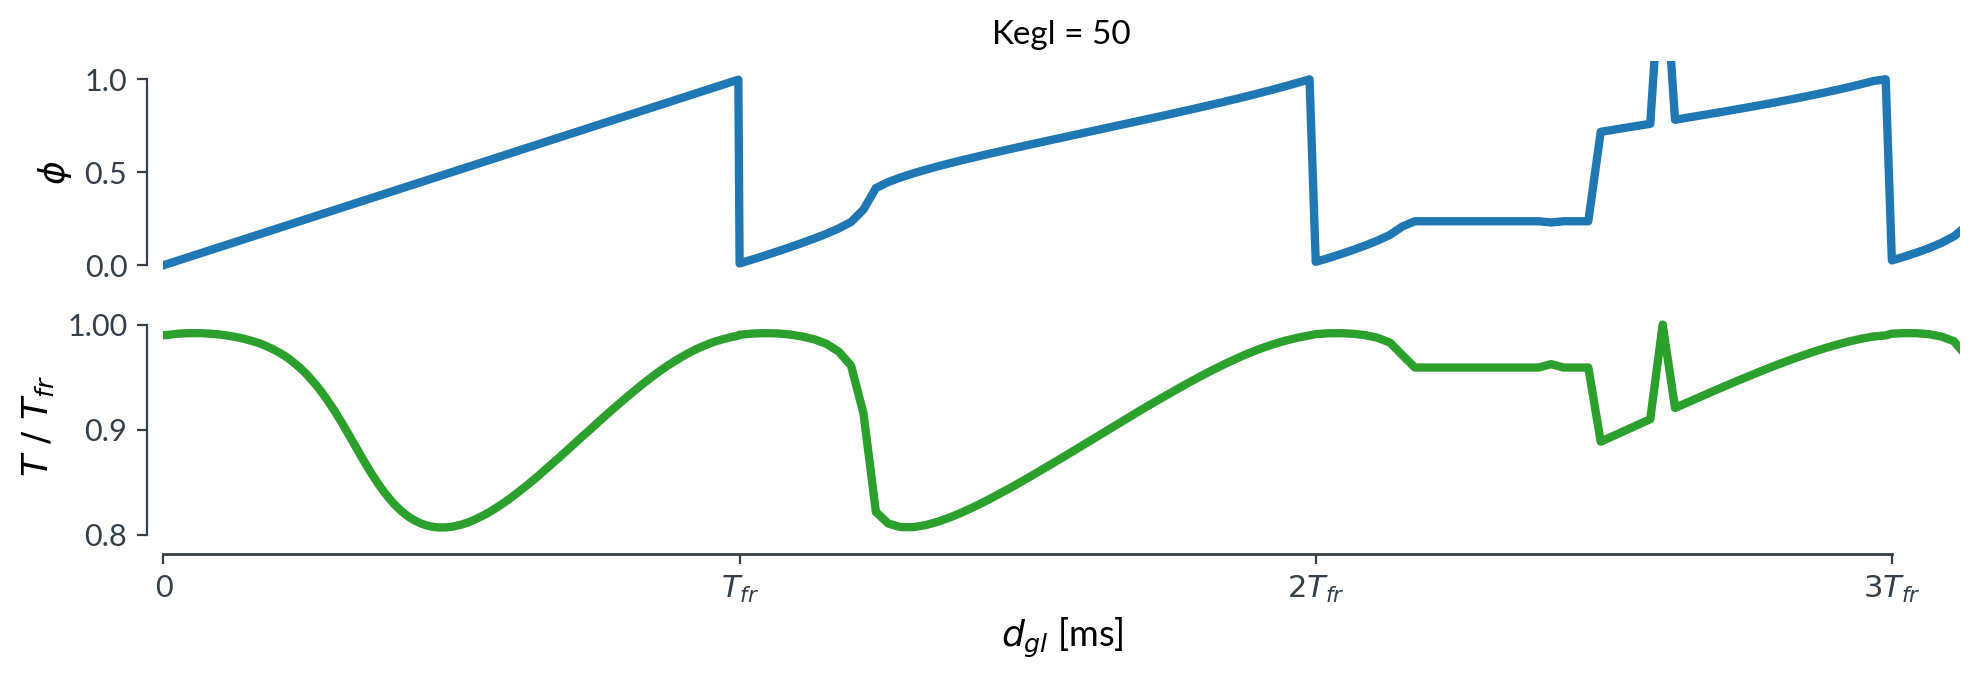

In [9]:
plt.rcParams['font.family'] = 'Lato'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

fig, axs = plt.subplots(2,1, figsize=(10, 3.5), dpi=200, sharex=True)
axs[0].plot(d, p/prc.frperiod, lw=3)
axs[1].plot(d, T / prc.frperiod, lw=3, color="tab:green")

axs[0].set_ylabel(r"$\phi$")
axs[1].set_ylabel(r"$T \ / \ T_{fr}$")
axs[1].set_xlabel(r"$d_{gl}$ [ms]")

axs[0].set_xlim(0, 145)
axs[0].set_ylim(-0.1, 1.1)

axs[1].set_xticks([0, prc.frperiod, 2*prc.frperiod, 3*prc.frperiod])
axs[1].set_xticklabels(labels=['0', r'$T_{fr}$', r'$2T_{fr}$', r'$3T_{fr}$'])

axs[0].set_yticks([0, 0.5, 1])
axs[0].set_yticklabels(['0.0', '0.5', '1.0'])

axs[1].set_yticks([0.8, 0.9, 1])
axs[1].set_yticklabels(['0.8', '0.9', '1.00'])

axs[0].tick_params(right=False, top=False, bottom=False)
axs[1].tick_params(right=False, top=False)

axs[0].spines["top"].set_visible(False), axs[0].spines["right"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[1].spines["top"].set_visible(False), axs[1].spines["right"].set_visible(False)

plt.draw()

lab = [float(item.get_text().replace("−", "-")) for item in axs[0].get_yticklabels(which='both')]
axs[0].spines["left"].set_bounds(low=min(lab), high=max(lab))
axs[0].spines["left"].set_position(("outward", 6))

lab = [float(item.get_text().replace("−", "-")) for item in axs[1].get_yticklabels(which='both')][:]
axs[1].spines["left"].set_bounds(low=min(lab), high=max(lab))
axs[1].spines["left"].set_position(("outward", 6))

axs[1].spines["bottom"].set_bounds(low=0, high=3*prc.frperiod)

axs[1].spines["bottom"].set_linewidth(1)
axs[1].spines["bottom"].set_position(("outward",6))

axs[0].set_title("Kegl = 50")

fig.tight_layout()
#fig.savefig("Pics/One_Node_Phases_Periods.pdf")

## calc eq. phases graphically

In [10]:
Phases_s = {} # store phases of stable modes for delays
Phases_u = {} # store phases of unstable modes for delays

# k = 1
ds = np.arange(0, prc.frperiod, 0.2)
for d in ds:
    Phases_s[d] = [d]
    
for k in [2, 3]:
    f_phases = []
    for d in tqdm(np.arange(0.85*(k-1) * prc.frperiod, 1.1* k * prc.frperiod, 0.1)):            
        goal = d/(k-1) - prc.frperiod

        x1 = np.arange(0, prc.frperiod, 0.1)
        y1 = x1/(k-1) - prc_func(x1)

        x2 = np.arange(0, prc.frperiod, 0.1)
        y2 = [goal] * len(x2)

        x,y = intersection(x1, y1, x2, y2)
        
        if len(x) == 0:
            continue
        for i in range(len(x)):
            phi = x[i]

            ## find slope of PRC at intersection phase
            xs = np.arange(phi - 0.01, phi + 0.01, 0.001)
            m1 = np.gradient(prc_func(xs), xs)[10] # this could misbehaves at end of PRC -> jump to 0
            
            if k == 2:
                eigenv = m1
            else:
                # construct mapping matrix 
                A = np.zeros((k-1, k-1))
                # fill 1. row with m
                for j in range(0, k-1):
                    A[0][j] = m1
                # fill appropiate 1s for system of eqs. 
                for j in range(k-1):
                    if j == 0:
                        pass
                    else:
                        A[j][j-1] = 1

                eigenvs = np.linalg.eig(A)[0]
                eigenv = np.max(np.real(eigenvs))
            if eigenv < 1:  # stable    
                if not d in Phases_s.keys():
                    Phases_s[d] = []
                Phases_s[d].append(phi)
            else:
                if not d in Phases_u.keys():
                    Phases_u[d] = []
                Phases_u[d].append(phi)
                        


100%|██████████| 745/745 [00:55<00:00, 13.42it/s]


In [11]:
d_s = np.asarray(list(Phases_s.keys()))
d_u = np.asarray(list(Phases_u.keys()))

p_s = list(Phases_s.values())
p_u = list(Phases_u.values())
#T = prc.frperiod - prc_func(p)
p = p_s
d = d_s

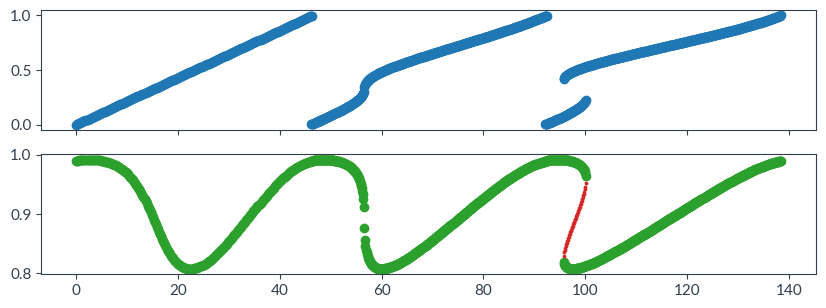

In [12]:
fig, axs = plt.subplots(2,1, figsize=(10, 3.5), dpi=100, sharex=True)
for i in range(len(d)):
    for j in range(len(p[i])):
        axs[0].scatter(d[i], p[i][j] / prc.frperiod, c="tab:blue")
        
for i in range(len(d)):
    for j in range(len(p[i])):
        axs[1].scatter(d[i], ( prc.frperiod - prc_func(p[i][j]) ) / prc.frperiod, c="tab:green") 

for i in range(len(d_u)):
    for j in range(len(p_u[i])):
        axs[1].scatter(d_u[i], ( prc.frperiod - prc_func(p_u[i][j]) ) / prc.frperiod, c="tab:red", s=3)  

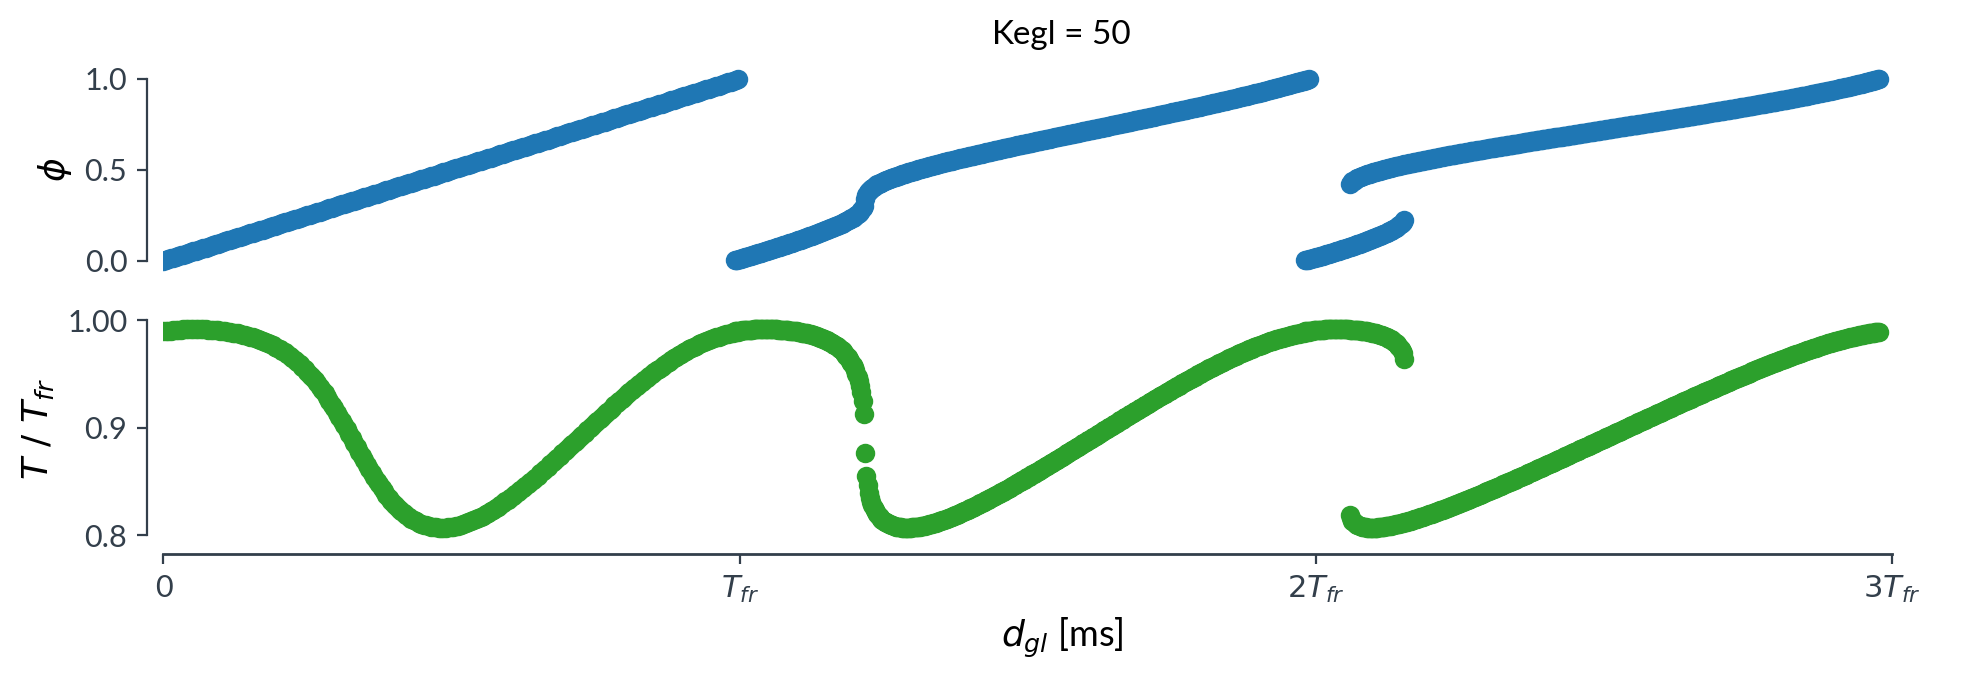

In [13]:
plt.rcParams['font.family'] = 'Lato'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

fig, axs = plt.subplots(2,1, figsize=(10, 3.5), dpi=200, sharex=True)
for i in range(len(d)):
    for j in range(len(p[i])):
        axs[0].scatter(d[i], p[i][j] / prc.frperiod, c="tab:blue")
        
for i in range(len(d)):
    for j in range(len(p[i])):
        axs[1].scatter(d[i], ( prc.frperiod - prc_func(p[i][j]) ) / prc.frperiod, c="tab:green")        
#axs[0].plot(d, p/prc.frperiod, lw=3)
#axs[1].plot(d, T / prc.frperiod, lw=3, color="tab:green")

axs[0].set_ylabel(r"$\phi$")
axs[1].set_ylabel(r"$T \ / \ T_{fr}$")
axs[1].set_xlabel(r"$d_{gl}$ [ms]")

axs[0].set_xlim(0, 145)
axs[0].set_ylim(-0.1, 1.1)

axs[1].set_xticks([0, prc.frperiod, 2*prc.frperiod, 3*prc.frperiod])
axs[1].set_xticklabels(labels=['0', r'$T_{fr}$', r'$2T_{fr}$', r'$3T_{fr}$'])

axs[0].set_yticks([0, 0.5, 1])
axs[0].set_yticklabels(['0.0', '0.5', '1.0'])

axs[1].set_yticks([0.8, 0.9, 1])
axs[1].set_yticklabels(['0.8', '0.9', '1.00'])

axs[0].tick_params(right=False, top=False, bottom=False)
axs[1].tick_params(right=False, top=False)

axs[0].spines["top"].set_visible(False), axs[0].spines["right"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[1].spines["top"].set_visible(False), axs[1].spines["right"].set_visible(False)

plt.draw()

lab = [float(item.get_text().replace("−", "-")) for item in axs[0].get_yticklabels(which='both')]
axs[0].spines["left"].set_bounds(low=min(lab), high=max(lab))
axs[0].spines["left"].set_position(("outward", 6))

lab = [float(item.get_text().replace("−", "-")) for item in axs[1].get_yticklabels(which='both')][:]
axs[1].spines["left"].set_bounds(low=min(lab), high=max(lab))
axs[1].spines["left"].set_position(("outward", 6))

axs[1].spines["bottom"].set_bounds(low=0, high=3*prc.frperiod)

axs[1].spines["bottom"].set_linewidth(1)
axs[1].spines["bottom"].set_position(("outward",6))

axs[0].set_title("Kegl = 50")

fig.tight_layout()
#fig.savefig("Pics/One_Node_Phases_Periods.pdf")

# sort to create lines

In [14]:
## k = 1
k1d = []
k1p = []
for i in range(len(d)):
    if d[i] <= prc.frperiod*0.99:
        for j in range(len(p[i])): # possible multiple phi values fro one delay
            k1d.append(d[i])
            k1p.append(p[i][j])

sort = np.argsort(k1p)
k1d = np.asarray(k1d)[sort]
k1p = np.asarray(k1p)[sort]

## k = 2 
k2d = []
k2p = []
for i in range(len(d)):
    if (d[i] > prc.frperiod) & (d[i] < 1.99*prc.frperiod):
        for j in range(len(p[i])): # possible multiple phi values fro one delay
            k2d.append(d[i])
            k2p.append(p[i][j])

sort = np.argsort(k2p)
k2d = np.asarray(k2d)[sort]
k2p = np.asarray(k2p)[sort]

## k = 3
k3d_s = []
k3p_s = []

for i in range(len(d)):
    if (d[i] >= 1.99*prc.frperiod) & (d[i] < 2.99):
        for j in range(len(p[i])): # possible multiple phi values fro one delay
            k3d_s.append(d[i])
            k3p_s.append(p[i][j])
            
sort = np.argsort(k3p_s)
k3d_s = np.asarray(k3d_s)[sort]
k3p_s = np.asarray(k3p_s)[sort]

k3d_u = []
k3p_u = []

for i in range(len(d_u)):
    if (d_u[i] >= 1.99*prc.frperiod) & (d_u[i] < 2.99):
        for j in range(len(p_u[i])): # possible multiple phi values fro one delay
            k3d_u.append(d_u[i])
            k3p_u.append(p_u[i][j])
            
#sort = np.argsort(k3p_u)
#k3d_u = np.asarray(k3d_u)[sort]
#k3p_u = np.asarray(k3p_u)[sort]

'''
## k = 4
k4d = []
k4p = []
for i in range(len(d)):
    if d[i] >= 1.99*prc.frperiod:
        for j in range(len(p[i])): # possible multiple phi values fro one delay
            k4d.append(d[i])
            k4p.append(p[i][j])
            
sort = np.argsort(k4p)
k4d = np.asarray(k4d)[sort]
k4p = np.asarray(k4p)[sort]
'''

'\n## k = 4\nk4d = []\nk4p = []\nfor i in range(len(d)):\n    if d[i] >= 1.99*prc.frperiod:\n        for j in range(len(p[i])): # possible multiple phi values fro one delay\n            k4d.append(d[i])\n            k4p.append(p[i][j])\n            \nsort = np.argsort(k4p)\nk4d = np.asarray(k4d)[sort]\nk4p = np.asarray(k4p)[sort]\n'

In [15]:
## k = 1
k1d = []
k1p = []
## k = 2 
k2d = []
k2p = []
## k = 3
k3d = []
k3p = []
## k = 4
k4d = []
k4p = []
for i in range(len(d)):
    for j in range(len(p[i])): # possible multiple phi values fro one delay
        if np.isclose(d[i] - p[i][j], 0, atol=5):
            k1d.append(d[i])
            k1p.append(p[i][j])
        elif np.isclose(d[i] - p[i][j], prc.frperiod, atol=10):
            k2d.append(d[i])
            k2p.append(p[i][j])
        elif np.isclose(d[i] - p[i][j], 2*prc.frperiod, atol=18):
            k3d.append(d[i])
            k3p.append(p[i][j])
        else:
            k4d.append(d[i])
            k4p.append(p[i][j])        

## k = 3 unstable
k3d_u = []
k3p_u = []
for i in range(len(d_u)):
    for j in range(len(p_u[i])):
        k3d_u.append(d_u[i])
        k3p_u.append(p_u[i][j])
        
sort = np.argsort(k1p)
k1d = np.asarray(k1d)[sort]
k1p = np.asarray(k1p)[sort]

sort = np.argsort(k2p)
k2d = np.asarray(k2d)[sort]
k2p = np.asarray(k2p)[sort]

sort = np.argsort(k3p)
k3d = np.asarray(k3d)[sort]
k3p = np.asarray(k3p)[sort]

sort = np.argsort(k3p_u)
k3d_u = np.asarray(k3d_u)[sort]
k3p_u = np.asarray(k3p_u)[sort]


sort = np.argsort(k4p)
k4d = np.asarray(k4d)[sort]
k4p = np.asarray(k4p)[sort]

In [16]:
k3d_1 = k3d[:81]
k3p_1 = k3p[:81]
k3d_2 = k3d[81:]
k3p_2 = k3p[81:]

 # with my style

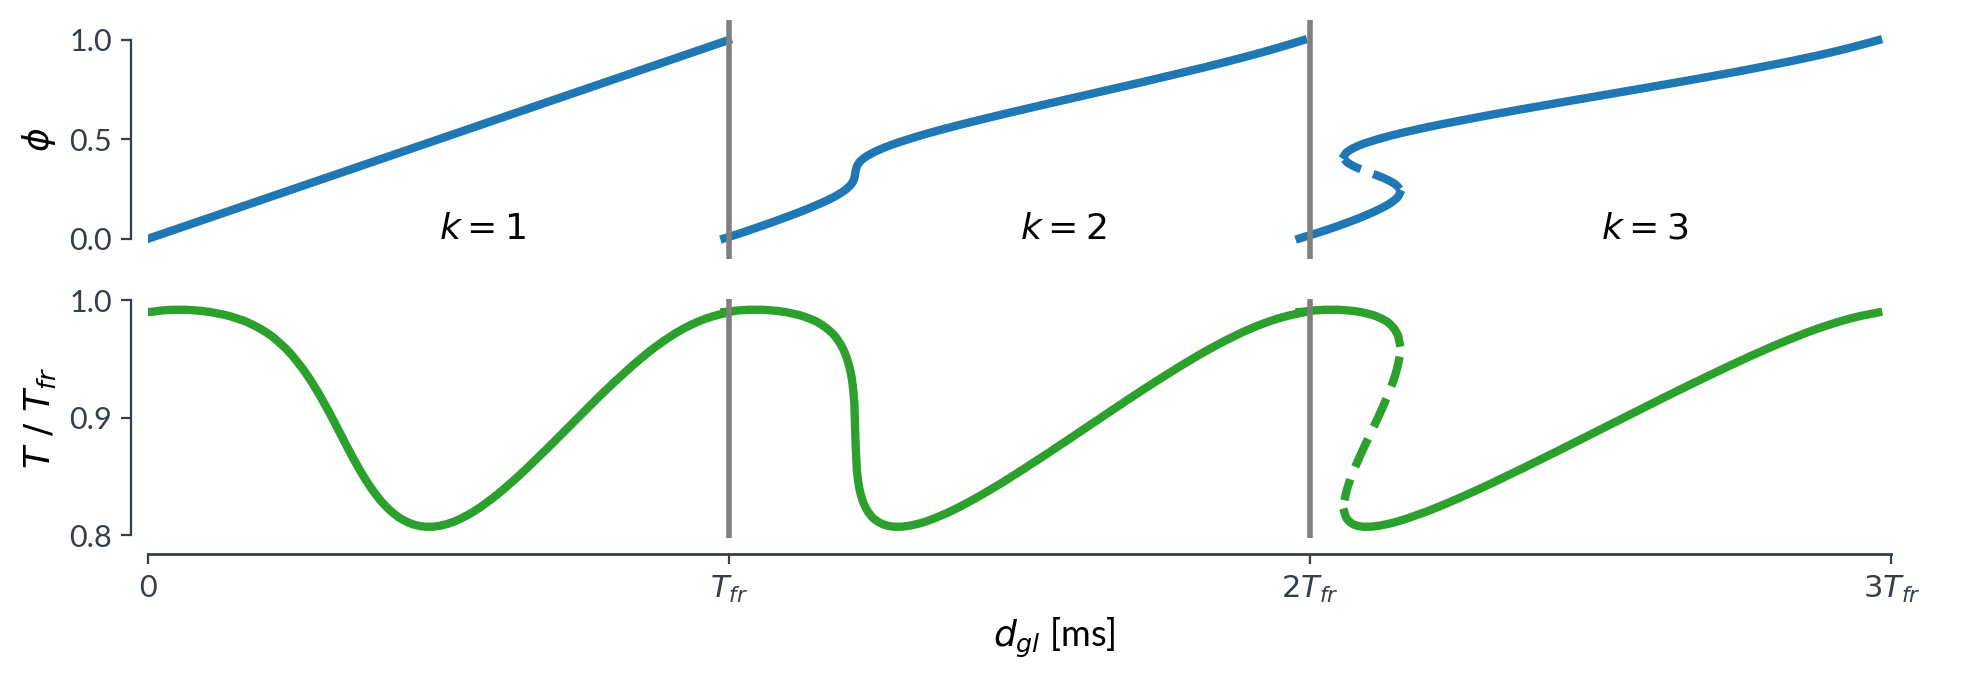

In [17]:
plt.rcParams['font.family'] = 'Lato'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

fig, axs = plt.subplots(2,1, figsize=(10, 3.5), dpi=200, sharex=True)
axs[0].plot(k1d, k1p / prc.frperiod, c="tab:blue", lw=3)
axs[0].plot(k2d, k2p / prc.frperiod, c="tab:blue", lw=3)
axs[0].plot(k3d_1, k3p_1 / prc.frperiod, c="tab:blue", lw=3)
axs[0].plot(k3d_2, k3p_2 / prc.frperiod, c="tab:blue", lw=3)
axs[0].plot(k3d_u, k3p_u / prc.frperiod, "--", c="tab:blue", lw=3)

#axs[0].plot(k4d, k4p / prc.frperiod, c="tab:blue", lw=3, alpha=0.5)


axs[1].plot(k1d, (prc.frperiod - prc_func(k1p))/ prc.frperiod, c="tab:green", lw=3)
axs[1].plot(k2d, (prc.frperiod - prc_func(k2p))/ prc.frperiod, c="tab:green", lw=3)
axs[1].plot(k3d_1, (prc.frperiod - prc_func(k3p_1))/ prc.frperiod, c="tab:green", lw=3)
axs[1].plot(k3d_2, (prc.frperiod - prc_func(k3p_2))/ prc.frperiod, c="tab:green", lw=3)

axs[1].plot(k3d_u, (prc.frperiod - prc_func(k3p_u))/ prc.frperiod, "--", c="tab:green", lw=3)


axs[0].text(prc.frperiod/2, 0, r'$k = 1$', size=13)
axs[0].text(3*prc.frperiod/2, 0, r'$k = 2$', size=13)
axs[0].text(5*prc.frperiod/2, 0, r'$k = 3$', size=13)

axs[0].axvline(prc.frperiod, c="grey", lw=2)
axs[1].axvline(prc.frperiod, c="grey", lw=2)

axs[0].axvline(2*prc.frperiod, c="grey", lw=2)
axs[1].axvline(2*prc.frperiod, c="grey", lw=2)



axs[0].set_ylabel(r"$\phi$")
axs[1].set_ylabel(r"$T \ / \ T_{fr}$")
axs[1].set_xlabel(r"$d_{gl}$ [ms]")

axs[0].set_xlim(0, 145)
axs[0].set_ylim(-0.1, 1.1)

axs[1].set_xticks([0, prc.frperiod, 2*prc.frperiod, 3*prc.frperiod])
axs[1].set_xticklabels(labels=['0', r'$T_{fr}$', r'$2T_{fr}$', r'$3T_{fr}$'])

axs[0].set_yticks([0, 0.5, 1])
axs[0].set_yticklabels(['0.0', '0.5', '1.0'])

axs[1].set_yticks([0.8, 0.9, 1])
axs[1].set_yticklabels(['0.8', '0.9', '1.0'])

axs[0].tick_params(right=False, top=False, bottom=False)
axs[1].tick_params(right=False, top=False)

axs[0].spines["top"].set_visible(False), axs[0].spines["right"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[1].spines["top"].set_visible(False), axs[1].spines["right"].set_visible(False)

plt.draw()

lab = [float(item.get_text().replace("−", "-")) for item in axs[0].get_yticklabels(which='both')]
axs[0].spines["left"].set_bounds(low=min(lab), high=max(lab))
axs[0].spines["left"].set_position(("outward", 6))

lab = [float(item.get_text().replace("−", "-")) for item in axs[1].get_yticklabels(which='both')][:]
axs[1].spines["left"].set_bounds(low=min(lab), high=max(lab))
axs[1].spines["left"].set_position(("outward", 6))

axs[1].spines["bottom"].set_bounds(low=0, high=3*prc.frperiod)
axs[1].spines["bottom"].set_linewidth(1)
axs[1].spines["bottom"].set_position(("outward",6))



#axs[0].set_title("Kegl = 50")

fig.tight_layout()
#fig.savefig("Pics/One_Node_Phases_Periods.pdf")

## Simulations

In [19]:
Cmat = np.array([[1.0]])
Dmat = Cmat
aln_rec = MultiModel( ALNNetwork(connectivity_matrix=Cmat, delay_matrix=Dmat) )
    
aln_rec.params["backend"] = "numba"
aln_rec.params['dt'] = 0.01 # ms 
aln_rec.params['sampling_dt'] = 0.1
aln_rec.params["duration"] = 20.0 * 1000  # in ms
#aln_.params["sampling_dt"] = 1.0  # in ms

aln_rec.params["*EXC*a|m"] = 0.
aln_rec.params["*EXC*b"] = 0.

aln_rec.params["*EXC*input*mu"] = 1.1
aln_rec.params["*INH*input*mu"] = 0.5

aln_rec.params["*c_gl"] = 0.3 # as default in standard ALN
aln_rec.params["*EXC*Ke_gl"] = 0

aln_rec.run()
stage = aln_rec["r_mean_EXC"][0][5000 :]

ps = func.getPowerSpectrum(stage,
                          aln_rec.params['sampling_dt'],
                          maxfr=100,
                          spectrum_windowsize=50) # powerspectrum 

peaks, props = find_peaks(ps[1].T, height = -20)
domfreq =  ps[0][peaks[props['peak_heights'].argmax()]]  # dominant frequency of ts

mm_frperiod = 1000 / domfreq

INFO:root:Loading precomputed transfer functions from /home/ben/.local/lib/python3.7/site-packages/neurolib/models/multimodel/builder/../../aln/aln-precalc/quantities_cascade.h5
INFO:root:All transfer functions loaded.
INFO:root:Loading precomputed transfer functions from /home/ben/.local/lib/python3.7/site-packages/neurolib/models/multimodel/builder/../../aln/aln-precalc/quantities_cascade.h5
INFO:root:All transfer functions loaded.
INFO:root:ALNNet: Model initialized.
INFO:root:Initialising numba backend...
INFO:root:Compiling model definition to numba function...
INFO:root:Substituting helpers...
INFO:root:Replacing symbolic expressions with arrays...
INFO:root:Compiling python code using numba's njit...
INFO:root:Loading system from cache...
INFO:root:Integrating for 2000000 time steps...
INFO:root:Integration done.
INFO:root:`run` call took 25.08 s


In [20]:
mm_frperiod

46.98795180722892

In [21]:
prc.frperiod

46.50024473813021

In [22]:
del(aln_rec)

## test stimulus

In [25]:
class SineWithExpDecay(stim.Stimulus):
    """
    Exponentially decaying sine stimulus
    """

    def __init__(
        self, 
        freq, 
        amplitude, 
        offset=0, 
        tau=5.3, 
        start=None, 
        end=None, 
        n=1, 
        seed=None
    ):
        # save parameters as attributes
        self.freq = freq # in Hz
        self.period = 1000.0 / self.freq # in ms
        self.amplitude = amplitude
        self.offset = offset
        self.tau = tau
        # pass other params to parent class
        super().__init__(
            start=start, end=end, n=n, seed=seed
        )

    def generate_input(self, duration, dt):
        # this is a helper function that creates self.times vector
        self._get_times(duration=duration, dt=dt)
        
        # duration of nonzero stimulus
        dur = self.end - self.start
        dur_dt = dur / dt
        
        # decay time
        # if we want to have decay to 1/200 of amplitude
        # -> exp time constant = t / (ln(1/200)) ~ t / 5.3
        decay_len = dur / self.tau
        
        # from original sine stimulus
        sinusoid = self.amplitude \
                    * np.sin(2 * np.pi * self.times * (1.0 / self.period))
        
        # aftera quarter of duration, have an exp decay
        sinusoid[ int(dur_dt / 4) : ] *= np.exp(-(1/decay_len) * self.times[ :-int(dur_dt/4) ])
        sinusoid += self.offset
        return self._trim_stim(np.vstack([sinusoid] * self.n))


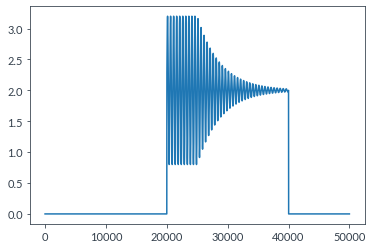

In [26]:
duration, dt = 5000, 0.1
# test ride
inp = SineWithExpDecay(
    freq=20.0, amplitude=1.2, offset=2, tau=5.3, n=1, start=2000, end=4000
).as_array(duration, dt)

plt.plot(inp.T)

In [28]:
def get_all_stim_freqs(delay):
    ''' System Frequency is function of delay can be approximated in two ways
    1. (synchroinzation_state + 1) x Period + 50 = 2 x delay 
    2. synchroniation_state x Period = 2 * delay 
    The second is a little worse but fits better to my theory.'''
    def method_one(state, sys_delay):
        period = (sys_delay+50) / (state+1)  
        return 1000 / period
    
    def method_two(state, sys_delay):
        if state == 0:
            period = sys_delay / (state+1)
        else:
            period = sys_delay / state
        period += 1
        return 1000 / period 

    ret = []
    for i in range(4, 8, 2):
        ret.append(method_one(state = i, sys_delay= 2 * delay))
    
    return ret

In [29]:
def eval_get_frequency(traj):
    pars = search.getParametersFromTraj(traj)
    delay = pars['delay']
    
    #Ke_gl = pars['Ke_gl']
    #num_stim = pars['num_stim']
        
    
    #aln_rec.params["*EXC*Ke_gl"] = Ke_gl
    sfreqs = [1000 / mm_frperiod, 1000 / (0.8*mm_frperiod)]

    freqs = np.ndarray((len(sfreqs)))
    periods = np.ndarray((len(sfreqs)))
    res = []
    
    for i, sfreq in enumerate(sfreqs):
        Cmat = np.array([[1.0]])
        Dmat = Cmat
        aln_rec = MultiModel( ALNNetwork(connectivity_matrix=Cmat, delay_matrix=Dmat) )

        aln_rec.params["backend"] = "numba"
        aln_rec.params['dt'] = 0.1 # ms 
        aln_rec.params['sampling_dt'] = 0.1
        aln_rec.params["duration"] = 20.0 * 1000  # in ms
        #aln_.params["sampling_dt"] = 1.0  # in ms

        aln_rec.params["*EXC*a|m"] = 0.
        aln_rec.params["*EXC*b"] = 0.

        aln_rec.params["*EXC*input*mu"] = 1.1
        aln_rec.params["*INH*input*mu"] = 0.5

        aln_rec.params["*c_gl"] = 0.3 # as default in standard ALN
        aln_rec.params["*EXC*Ke_gl"] = 50
        aln_rec.params["*delays|local"] = np.array([[delay]])
        
        stimulus = SineWithExpDecay(
            freq=1.*sfreq, 
            amplitude=1., 
            offset=0, 
            tau=5.3,
            n=1, 
            start=0, 
            end=2000, 
            seed=None
        )
        
        standardOU_exc = aln_rec.noise_input[0]
        standardOU_inh = aln_rec.noise_input[1]

        aln_rec.noise_input = [stimulus + standardOU_exc, standardOU_inh]
        # run
        aln_rec.run()

        # EVALUATION
        stage = aln_rec["r_mean_EXC"][0][ int(5000/aln_rec.params['sampling_dt']): ]
        re = aln_rec["r_mean_EXC"][0][ : int(3000 / aln_rec.params['sampling_dt'])][::10]
        peaks, props = find_peaks(stage.T)

        ps = func.getPowerSpectrum(stage,
                                  aln_rec.params['sampling_dt'],
                                  maxfr=100,
                                  spectrum_windowsize=50) # powerspectrum 

        peaks, props = find_peaks(ps[1].T, height = -20)
        domfreq =  ps[0][peaks[props['peak_heights'].argmax()]]  # dominant frequency of ts
        
        freqs[i] = domfreq
        periods[i] = 1000 / domfreq 
        #res.append(re)
        
    result_dict = {"delay" : delay, 
                   "frequencies" : freqs,
                   "periods" : periods}
                   #"re": np.asarray(res)}
    
    search.saveToPypet(result_dict, traj)
    return

In [41]:
Cmat = np.array([[1.0]])
Dmat = Cmat
aln_rec = MultiModel( ALNNetwork(connectivity_matrix=Cmat, delay_matrix=Dmat) )
    
aln_rec.params["backend"] = "numba"
aln_rec.params['dt'] = 0.01 # ms 
aln_rec.params['sampling_dt'] = 0.01
aln_rec.params["duration"] = 20.0 * 1000  # in ms
#aln_.params["sampling_dt"] = 1.0  # in ms

aln_rec.params["*EXC*a|m"] = 0.
aln_rec.params["*EXC*b"] = 0.

aln_rec.params["*EXC*input*mu"] = 1.1
aln_rec.params["*INH*input*mu"] = 0.5

aln_rec.params["*c_gl"] = 0.3 # as default in standard ALN
aln_rec.params["*EXC*Ke_gl"] = 50

delay = np.linspace(0, 140, 141) 
#kes = np.linspace(10, 100, 10)
parameters = ParameterSpace({"delay": delay})
#                             "num_stim": range(4)})
#parameters = ParameterSpace({"delay": np.array([99.])})

search = BoxSearch(evalFunction = eval_get_frequency,
                   parameterSpace=parameters,
                   #filename=HDF_PATH+'TwoNode_delay_stim_LCmiddle_multistab.hdf')
                    filename=HDF_PATH+'MM_OneNode_Recurrency_PRC_Prediction_Ke=50_withRates.hdf',
                    ncores=6)

MainProcess root INFO     Loading precomputed transfer functions from /home/ben/.local/lib/python3.7/site-packages/neurolib/models/multimodel/builder/../../aln/aln-precalc/quantities_cascade.h5
MainProcess root INFO     All transfer functions loaded.
MainProcess root INFO     Loading precomputed transfer functions from /home/ben/.local/lib/python3.7/site-packages/neurolib/models/multimodel/builder/../../aln/aln-precalc/quantities_cascade.h5
MainProcess root INFO     All transfer functions loaded.
MainProcess root INFO     ALNNet: Model initialized.
MainProcess root INFO     Number of processes: 6
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/MM_OneNode_Recurrency_PRC_Prediction_Ke=50_withRates.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 141
MainProcess root INFO     BoxSearch: Environment initialized.


In [ ]:
#search.run()

In [42]:
search.loadResults()

MainProcess root INFO     Loading results from ./data/hdf/../../../../Data/MM_OneNode_Recurrency_PRC_Prediction_Ke=50_withRates.hdf
MainProcess root INFO     Analyzing trajectory results-2021-12-01-12H-01M-29S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/../../../../Data/MM_OneNode_Recurrency_PRC_Prediction_Ke=50_withRates.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2021-12-01-12H-01M-29S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Loading all results to `results` dictionary ...
100%|██████████| 141/141 [00:01<00:00, 109.03it/s]
MainProcess root 

In [43]:
#T = mm_frperiod- prc_func(p)
t_diff = mm_frperiod / prc.frperiod
#d_new = d * t_diff

98.0
99.0
100.0
137.0
138.0
139.0
140.0


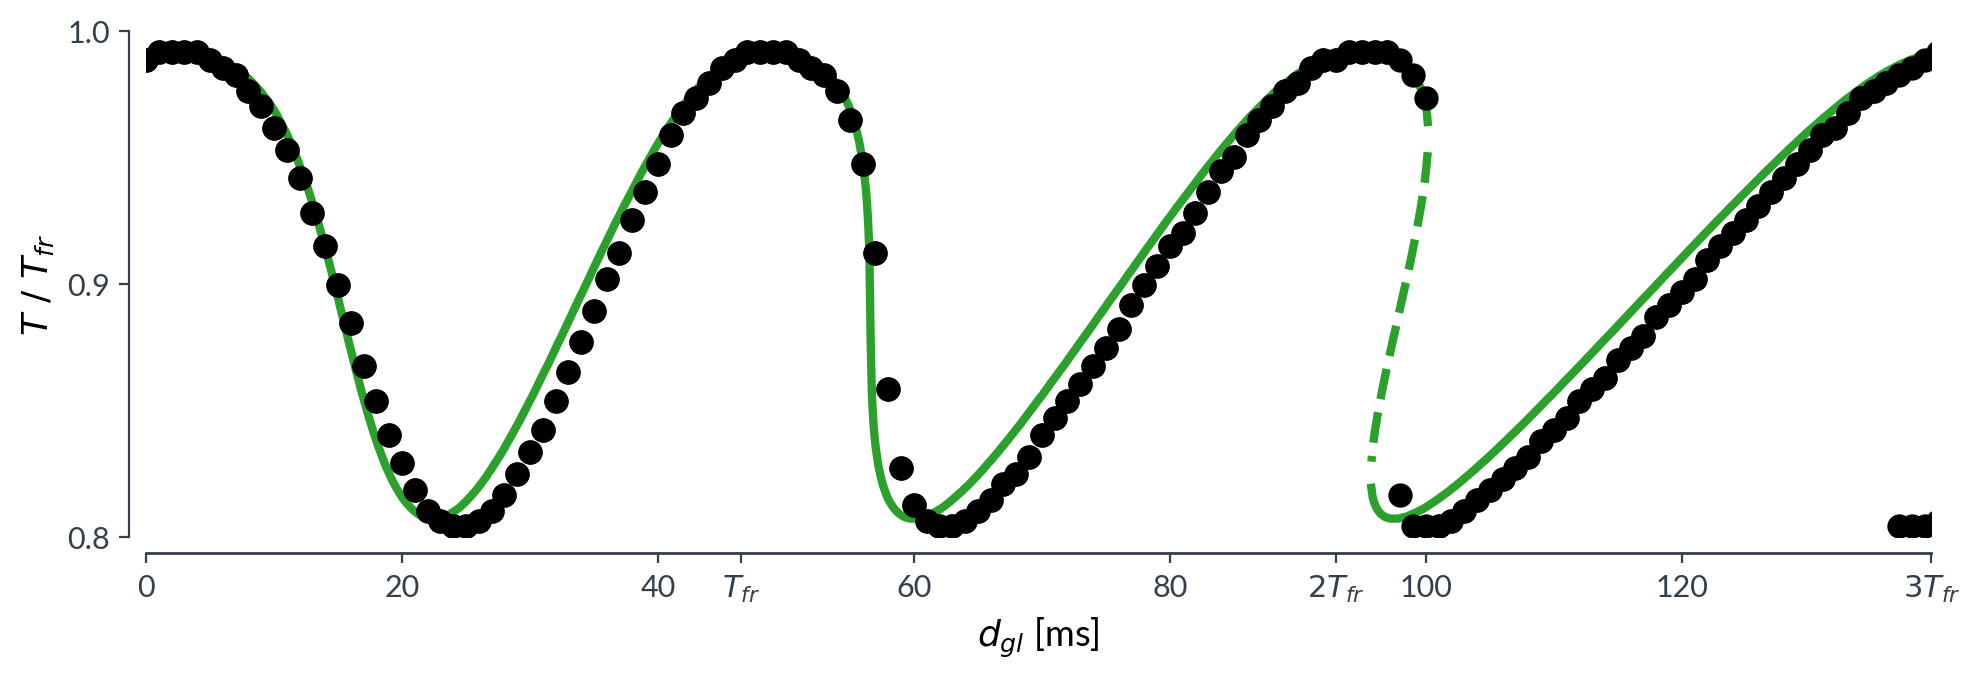

In [44]:
plt.rcParams['font.family'] = 'Lato'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

fig, ax = plt.subplots(figsize=(10, 3.5), dpi=200)



ax.plot(k1d, (prc.frperiod - prc_func(k1p))/ prc.frperiod, c="tab:green", lw=3)
ax.plot(k2d, (prc.frperiod - prc_func(k2p))/ prc.frperiod, c="tab:green", lw=3)
ax.plot(k3d_1, (prc.frperiod - prc_func(k3p_1))/ prc.frperiod, c="tab:green", lw=3)
ax.plot(k3d_2, (prc.frperiod - prc_func(k3p_2))/ prc.frperiod, c="tab:green", lw=3)

ax.plot(k3d_u, (prc.frperiod - prc_func(k3p_u))/ prc.frperiod, "--", c="tab:green", lw=3)

#for d in np.arange(0, 141, 1):
 ##   per = 1000 / np.asarray(get_all_stim_freqs(d))
#    for p in per:
#        ax.scatter(d, p / prc.frperiod)
        
delays = search.dfResults.delay.drop_duplicates()

Ke = 50.
for delay in delays:
    df = search.dfResults[(search.dfResults.delay  == delay) ]
    for i in df.index:
        if df.periods[i][0] != df.periods[i][1]:
            print(delay)
        for j in range(len(df.periods[i])):
            ax.scatter(delay , df.periods[i][j] /mm_frperiod, c="black", s=60, zorder=4., label="Simulation")

ax.set_ylabel(r"$T \ / \ T_{fr}$")
ax.set_xlabel(r"$d_{gl}$ [ms]")

ax.set_xlim(0, 60)
ax.set_xticks([0, 20, 40, 60, 80, 100, 120, prc.frperiod, 2*prc.frperiod, 3*prc.frperiod])
ax.set_xticklabels(labels=['0', '20', '40', '60', '80', '100', '120',r'$T_{fr}$', r'$2T_{fr}$', r'$3T_{fr}$'])

ax.set_ylim(0.8, 1.)
ax.set_yticks([0.8, 0.9, 1])
ax.set_yticklabels(['0.8', '0.9', '1.0'])

ax.tick_params(right=False, top=False)

ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)

plt.draw()

lab = [float(item.get_text().replace("−", "-")) for item in ax.get_yticklabels(which='both')][:]
ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
ax.spines["left"].set_position(("outward", 6))

ax.spines["bottom"].set_bounds(low=0, high=3*prc.frperiod)

ax.spines["bottom"].set_linewidth(1)
ax.spines["bottom"].set_position(("outward",6))

fig.tight_layout()
#fig.savefig("Pics/One_Node_Periods_with_Simulation.pdf")

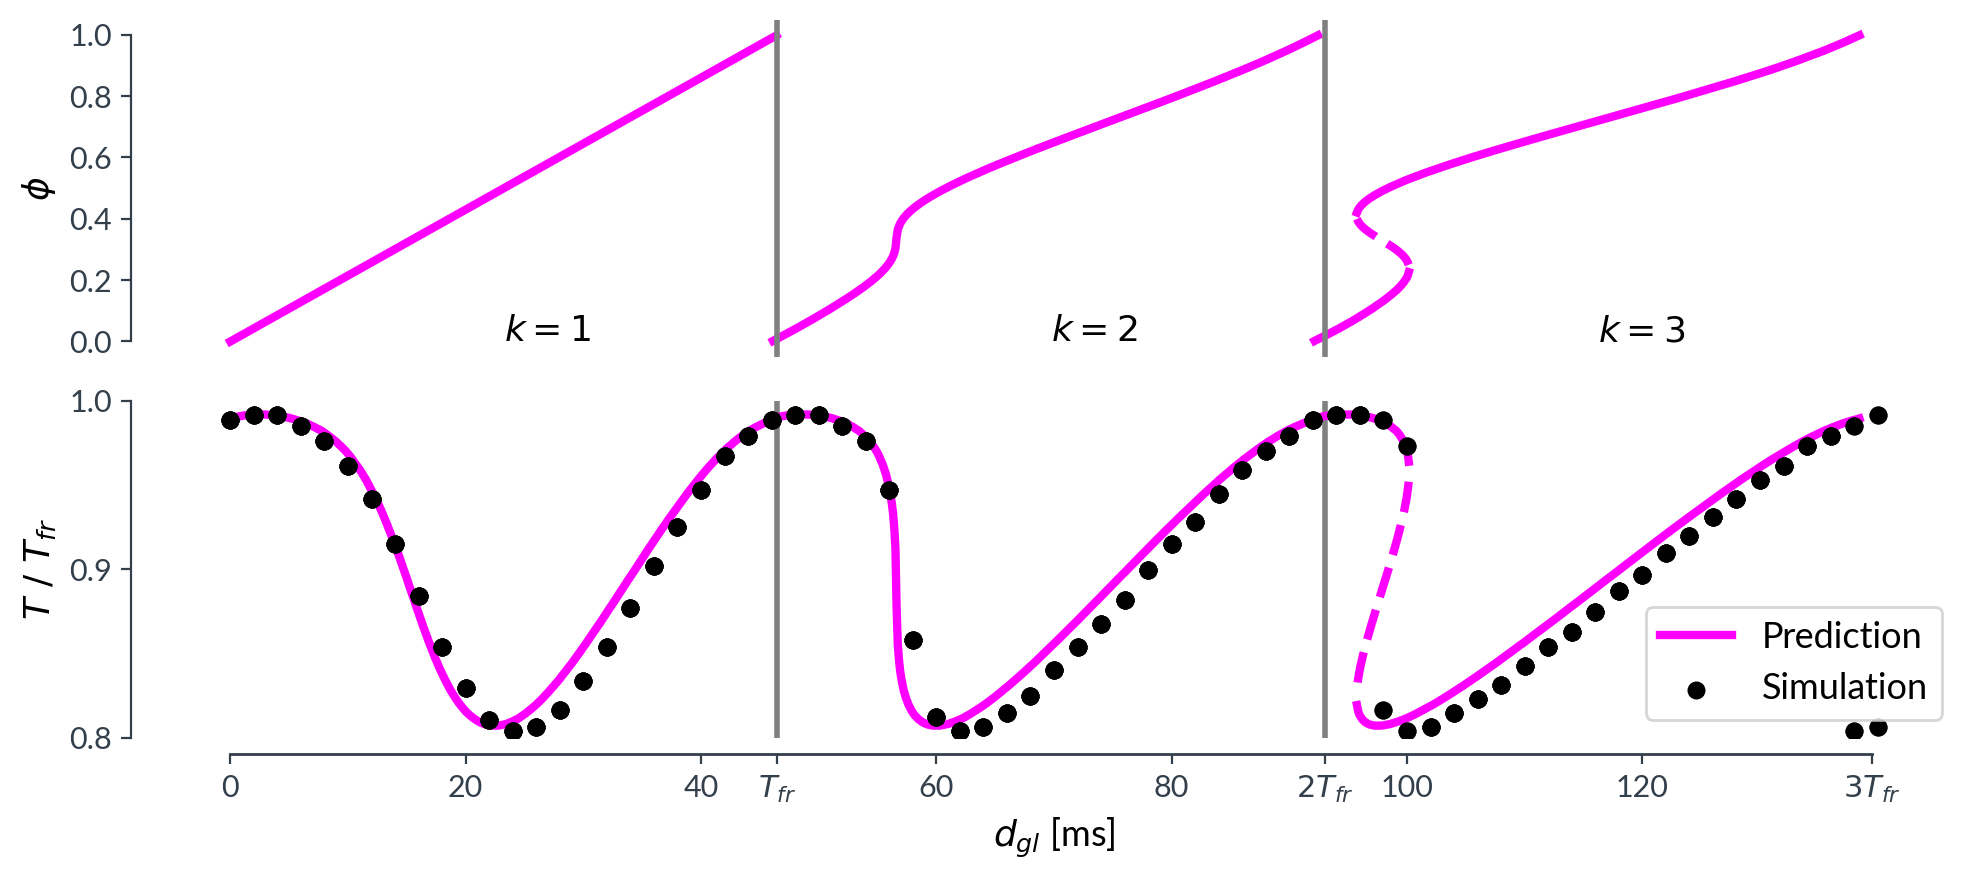

In [46]:
plt.rcParams['font.family'] = 'Lato'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    handles, labels = [*zip(*unique)]
    #handles2 = handles[:3] + (circ1, circ1)[:-1]
    #labels2 = labels[:3] + ("simulated", "sim")[:-1]
    #ic(type(labels))
    #ic(handles2, labels2)
    ax.legend(handles, labels, loc = "lower right")
    
    
fig, axs = plt.subplots(2,1, figsize=(10, 4.5), dpi=200, sharex=True)
axs[0].plot(k1d, k1p / prc.frperiod, c="fuchsia", lw=3)
axs[0].plot(k2d, k2p / prc.frperiod, c="fuchsia", lw=3)
axs[0].plot(k3d_1, k3p_1 / prc.frperiod, c="fuchsia", lw=3)
axs[0].plot(k3d_2, k3p_2 / prc.frperiod, c="fuchsia", lw=3)
axs[0].plot(k3d_u, k3p_u / prc.frperiod, "--", c="fuchsia", lw=3)

axs[0].text(prc.frperiod/2, 0, r'$k = 1$', size=13)
axs[0].text(3*prc.frperiod/2, 0, r'$k = 2$', size=13)
axs[0].text(5*prc.frperiod/2, 0, r'$k = 3$', size=13)

axs[0].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1])
axs[0].set_yticklabels(['0.0','0.2','0.4','0.6', '0.8', '1.0'])

axs[0].axvline(prc.frperiod, c="grey", lw=2)
axs[1].axvline(prc.frperiod, c="grey", lw=2)

axs[0].axvline(2*prc.frperiod, c="grey", lw=2)
axs[1].axvline(2*prc.frperiod, c="grey", lw=2)

axs[1].plot(k1d, (prc.frperiod - prc_func(k1p))/ prc.frperiod, c="fuchsia", lw=3)
axs[1].plot(k2d, (prc.frperiod - prc_func(k2p))/ prc.frperiod, c="fuchsia", lw=3)
axs[1].plot(k3d_1, (prc.frperiod - prc_func(k3p_1))/ prc.frperiod, c="fuchsia", lw=3)
axs[1].plot(k3d_2, (prc.frperiod - prc_func(k3p_2))/ prc.frperiod, c="fuchsia", lw=3, label="Prediction")

axs[1].plot(k3d_u, (prc.frperiod - prc_func(k3p_u))/ prc.frperiod, "--", c="fuchsia", lw=3)

#for d in np.arange(0, 141, 1):
 ##   per = 1000 / np.asarray(get_all_stim_freqs(d))
#    for p in per:
#        ax.scatter(d, p / prc.frperiod)
        
delays = search.dfResults.delay.drop_duplicates()

Ke = 50.
for delay in delays[::2]:
    df = search.dfResults[  (search.dfResults.delay  == delay) ]
    for i in df.index:
        for j in range(len(df.periods[i])):
            for j in range(len(df.periods[i])):
                axs[1].scatter(delay, df.periods[i][j] /mm_frperiod, c="black", s=30, zorder=4., label="Simulation")

axs[0].set_ylabel(r"$\phi$")
axs[1].set_ylabel(r"$T \ / \ T_{fr}$")
axs[1].set_xlabel(r"$d_{gl}$ [ms]")

#axs[1].set_xlim(0, 60)
axs[1].set_xticks([0, 20, 40, 60, 80, 100, 120, prc.frperiod, 2*prc.frperiod, 3*prc.frperiod])
axs[1].set_xticklabels(labels=['0', '20', '40', '60', '80', '100', '120',r'$T_{fr}$', r'$2T_{fr}$', r'$3T_{fr}$'])

axs[1].set_ylim(0.8, 1.)
axs[1].set_yticks([0.8, 0.9, 1])
axs[1].set_yticklabels(['0.8', '0.9', '1.0'])

axs[0].tick_params(right=False, top=False, bottom=False)
axs[1].tick_params(right=False, top=False)

axs[0].spines["top"].set_visible(False), axs[0].spines["right"].set_visible(False), axs[0].spines["bottom"].set_visible(False)
axs[1].spines["top"].set_visible(False), axs[1].spines["right"].set_visible(False)

#plt.draw()

lab = [float(item.get_text().replace("−", "-")) for item in axs[0].get_yticklabels(which='both')]
axs[0].spines["left"].set_bounds(low=min(lab), high=max(lab))
axs[0].spines["left"].set_position(("outward", 6))

lab = [float(item.get_text().replace("−", "-")) for item in axs[1].get_yticklabels(which='both')][:]
axs[1].spines["left"].set_bounds(low=min(lab), high=max(lab))
axs[1].spines["left"].set_position(("outward", 6))

axs[1].spines["bottom"].set_bounds(low=0, high=3*prc.frperiod)

axs[1].spines["bottom"].set_linewidth(1)
axs[1].spines["bottom"].set_position(("outward",6))

legend_without_duplicate_labels(axs[1])
fig.tight_layout()
#fig.savefig("Pics/One_Node_Phases_Periods_with_Simulation_2.pdf")